<a href="https://colab.research.google.com/github/pramodith/llm_exploration/blob/colab/exploring_sink_tokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Sink Tokens in Transformers
This notebook is associated with our Medium Article here, where we detail our exploration of encoder and decoder-only Transformer 
models and the existence of *sink tokens* in them.

At a high level *sink tokens* are a small group of tokens that transformer models use to offload a very high proportion of attention scores to. For more, please read our [article]().

In this notebook we'll visualize the attention scores of various models and identify the tokens which are allocated the highest amount of attention, on a layer-by-layer basis.

In [30]:
!pip install transformers
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00


In [74]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoModel
from enum import Enum
import torch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns

Enum of the different types of Transformer Models.

In [76]:
class ModelTypes(str, Enum):

  ENCODER = "ENCODER"
  DECODER = "DECODER"
  ENCODER_DECODER = "ENCODER_DECODER"


## Model and Tokenizer Loading
This function, `get_model_and_tokenizer`, is designed to load a specified model and its corresponding tokenizer from the Hugging Face library, which is a popular library for Natural Language Processing tasks.

The function takes two parameters:

1. `model_name`: This is a string that specifies the name of the model to be loaded. It should correspond to a model available in the Hugging Face model hub.

2. `model_type`: This is a string that specifies the type of the model to be loaded. It can be one of three values: 'encoder', 'decoder', or 'encoder-decoder'. These correspond to different types of language models.

The function first checks the `model_type` and loads the corresponding model using the appropriate Hugging Face function (`AutoModelForMaskedLM`, `AutoModelForCausalLM`, or `AutoModelForSeq2SeqLM`). It then sets the model to evaluation mode with `model.eval()`.

Next, the function loads the tokenizer corresponding to the model using `AutoTokenizer.from_pretrained(model_name)`. If the model type is not 'encoder', __it sets the padding side of the tokenizer to the left__. This is because decoder models in transformer architectures typically expect padding to be on the left.

Finally, the function checks if the tokenizer has a pad token, and if not, it sets the pad token to be the same as the end-of-sentence (eos) token. This is because some models do not have a separate pad token, but still require padding for certain operations.

The function returns a tuple containing the loaded tokenizer and model.

In [28]:
def get_model_and_tokenizer(model_name: str, model_type: str) -> Tuple[AutoTokenizer, Union[AutoModelForMaskedLM, AutoModelForCausalLM, AutoModelForSeq2SeqLM]]:
  """
  This function loads the model and tokenizer from the huggingface library.
  @param model_name: name of the model to be loaded
  @param model_type: type of the model to be loaded i.e. encoder, decoder, encoder-decoder
  """
  if model_type == ModelTypes.ENCODER:
    model = AutoModelForMaskedLM.from_pretrained(model_name)
  elif model_type == ModelTypes.DECODER:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
  elif model_type == ModelTypes.ENCODER_DECODER:
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  else:
    raise ValueError("Invalid model type.")
  model = model.eval()
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # Set padding side to the left for decoder models
  if model_type != ModelTypes.ENCODER:
    tokenizer.padding_side = "left"

  # Add pad token if not present
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

  return tokenizer, model

## Tokenization and Identifying Non-Pad Tokens
This function, `tokenize`, is designed to tokenize input text using a specified tokenizer from the Hugging Face library, which is a popular library for Natural Language Processing tasks.

The function takes three parameters:

1. `tokenizer`: This is an instance of `AutoTokenizer` from the Hugging Face library. It is used to tokenize the input text.

2. `sample_text`: This is the text to be tokenized. It can be a single string or a list of strings.

3. `model_type`: This is a string that specifies the type of the model to be used. It can be 'encoder', 'decoder', or 'encoder-decoder'. These correspond to different types of language models.

The function first checks the `model_type` and if it's an 'encoder', it adds a space before and after the mask token in the `sample_text`.

Next, the function checks the type of `sample_text`. If it's a string, it tokenizes it as a single text sequence. If it's a list, it tokenizes each element as a separate text sequence. The tokenization is done using the `tokenizer`'s call method, which returns a dictionary of PyTorch tensors including input IDs and attention masks.

The function then converts the input IDs back into tokens for each sequence in `sample_text` using the `tokenizer.convert_ids_to_tokens()` method.

After that, the function finds the index of the first non-pad token and the first pad token in each sequence by looking at the attention mask. The attention mask is a binary tensor where positions with the value of 1 indicate non-pad tokens and positions with the value of 0 indicate pad tokens.

Finally, the function prints the tokens and returns a tuple containing the tokenized inputs (a dictionary of PyTorch tensors), the tokens (a list of strings or a list of list of strings), the indices of the first non-pad token (a list of integers), and the indices of the first pad token (a list of integers).

In [84]:
def tokenize(tokenizer: AutoTokenizer,
    sample_text: Union[str, List[str]],
    model_type: str,
    ) -> Tuple[Dict[str, torch.Tensor], List[List[str]], List[int], List[int]]:
    """
    This function tokenizes the input text using the tokenizer provided, maps the token indices to the corresponding tokens, 
    identifies the first non-pad token and 
    returns the tokenized input, tokens, the indices of the first non-pad token, and the indices of the first pad token.
    
    Args:
        tokenizer (AutoTokenizer): The tokenizer to be used for tokenization
        sample_text (Union[str, List[str]]): The documents to be tokenized

    Returns:
        Tuple[Dict[str, torch.Tensor], List[List[str]], List[int]]: The tokenized input, tokens, the indices of the first non-pad token, and the indices of the first pad token
    """

    # Add space before and after mask token for encoder models
    if model_type == ModelTypes.ENCODER:
      if isinstance(sample_text, str):
        sample_text += " " + (tokenizer.mask_token)
      else:
        sample_text = [s + " " + (tokenizer.mask_token) for s in sample_text]
    if isinstance(sample_text, str):
        # If sample_text is a string, tokenize it as a single text sequence
        inputs = tokenizer(sample_text, return_tensors="pt", padding=True)
        tokens = [tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in inputs.input_ids[0]]
    elif isinstance(sample_text, list):
        # If sample_text is a list, tokenize each element as a separate text sequence
        inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True)
        tokens = [[tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in input_ids] for input_ids in inputs.input_ids]
    else:
        raise ValueError("sample_text must be a string or a list of strings")
    non_pad_token_start_idx = [inputs.attention_mask[i].tolist().index(1) for i in range(len(inputs.attention_mask))]
    
    # Get index where padding starts
    padding_start_idx = []
    for i in range(len(inputs.attention_mask)):
      try:
        padding_start_idx.append(inputs.attention_mask[i].tolist().index(0))
      except ValueError:
        padding_start_idx.append(len(inputs.attention_mask[i].tolist()))

    for i in range(len(tokens)):
      if model_type == ModelTypes.ENCODER:
        print(f"Tokenized input:  {tokens[i][:padding_start_idx[i]]}")
      else:
        print(f"Tokenized input:  {tokens[i][non_pad_token_start_idx[i]:]}")
    return inputs, tokens, non_pad_token_start_idx, padding_start_idx

## Predict and Obtain Attention Scores 

The function `get_model_predictions_and_attention` is designed to generate predictions and attention weights from a given model and input.

Here's a detailed breakdown of its purpose and functionality:

- **Parameters:**
  - `inputs`: A dictionary of PyTorch tensors representing the input to the model.
  - `model`: An instance of `AutoModel` from the Hugging Face library. This is the model that will be used to generate predictions.
  - `tokenizer`: An instance of `AutoTokenizer` from the Hugging Face library. This is used to decode the predicted token IDs back into text.
  - `model_type`: A string indicating the type of the model. It can be 'encoder', 'decoder', or 'encoder-decoder'.


- **Functionality:**
  - The function first checks the `model_type` and generates predictions accordingly. If the model is an encoder, it gets the index of the mask token in each document in the batch and predicts the masked token. If the model is a decoder, it generates a sequence of tokens and gets the last token of the generated sequence. If the model is an encoder-decoder, it generates a single token using greedy decoding.
  - The function then prints the predictions and the number of layers in the model.
  - It also extracts the attention weights from the model output. The attention weights represent how much each token in the input sequence contributed to each token in the output sequence. They are returned as a list of PyTorch tensors, with one tensor for each layer in the model. Each tensor has a shape of [batch_size, num_heads, num_tokens, num_tokens].
  - The function then **averages the attention scores across the attention heads in each layer** and returns the averaged attention weights.


- **Returns:**
  - A list of PyTorch tensors representing the averaged attention weights for each layer in the model. The shape of each tensor is [num_layers, batch_size, num_tokens, num_tokens].

This function is useful for understanding how a model makes its predictions, as it allows you to see which tokens in the input sequence were most influential in generating each token in the output sequence.

In [6]:
def get_model_predictions_and_attention(inputs: Dict[str, torch.Tensor], model: AutoModel, tokenizer:AutoTokenizer, model_type: str) -> List[torch.Tensor]:
  """This function generates the predictions and attention weights for the given model and input.

  Args:
      inputs (Dict[str, torch.Tensor]): The input to the model
      model (AutoModel): The model to be used for prediction
      tokenizer (AutoTokenizer): The tokenizer used for tokenization
      model_type (str): The type of model to be used

  Raises:
      ValueError: If the model type is not supported

  Returns:
      List[torch.Tensor]: The attention weights for the given model and input
      Attention weights shape: [num_layers, batch_size, num_heads, num_tokens, num_tokens]
  """

  with torch.no_grad():
    if model_type == ModelTypes.ENCODER:
      output = model(**inputs, output_attentions=True)
      # Get the index of the mask token acroos each document in the batch
      mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
      predicted_token_ids = [output.logits[i, mask_token_index[i]].argmax() for i in range(len(output.logits))]
      print(f"Predictions for masked tokens are {tokenizer.batch_decode(predicted_token_ids)}")
      attention_weights = output.attentions

    elif model_type == ModelTypes.DECODER:
      output = model.generate(**inputs, output_attentions=True, return_dict_in_generate=True, max_length = len(inputs["input_ids"][0])+1, output_scores=True)
      # Get the last token of the generated sequence
      output_strings = tokenizer.batch_decode([output.sequences[i][-1] for i in range(len(output.sequences))],skip_special_tokens=False)
      print(f"Completion's are {output_strings}")
      # Get the attention weights for only the generated token excluding prompt tokens
      attention_weights = output.attentions[-1]

    elif model_type == ModelTypes.ENCODER_DECODER:
      # TODO: Ignore for now since this is incomplete, since ENCODER_DECODER models have three types of attentions (encoder, decoder, cross-attention).
      output = model.generate(**inputs, output_attentions=True, return_dict_in_generate=True, max_length = len(inputs["input_ids"][0])+1, do_sample=False)
      print(f"Completion is {tokenizer.decode(output.sequences[0],skip_special_tokens=False)}")
      attention_weights = output.encoder_attentions

    else:
      raise ValueError(f"{model_type} is not supported")

  print(f"{model_type} has {len(output.attentions[0])} Number of layers")
  print(attention_weights[0].shape)
  
  # Average attention scores across heads
  attention_weights = [torch.mean(attention_weights[i],axis=1) for i in range(len(attention_weights))]
  # Shape [num_layers,  batch_size, num_tokens, num_tokens]
  
  return attention_weights

## Track Special Tokens

The function `get_special_token_indices` is designed to identify and return the indices of special tokens like the __[CLS]__ token in a given tensor of token IDs.

Here's a detailed breakdown of its purpose and functionality:

- **Parameters:**
  - `token_ids`: A PyTorch tensor containing the IDs of tokens in a sequence.
  - `tokenizer`: An instance of `AutoTokenizer` from the Hugging Face library. This is used to identify the IDs of special tokens.

- **Functionality:**
  - The function first retrieves the IDs of all special tokens used by the tokenizer with `tokenizer.all_special_ids`.
  - It then attempts to remove the IDs of the pad token from the list of special token IDs. This is because these tokens are not considered during the self-attention operation.
  - The function then checks if there are any special token IDs left. If there are, it finds the indices of these tokens in the `token_ids` tensor using `torch.where(token_ids == i)[1].numpy()`. This returns a list of numpy arrays, each containing the indices of a specific special token in the `token_ids` tensor.
  - It then removes any empty arrays from the list (i.e., special tokens that were not found in the `token_ids` tensor).
  - If the list of special token indices is not empty, it sets `found_special_tokens` to `True`. Otherwise, it sets `found_special_tokens` to `False`.

- **Returns:**
  - A tuple containing the list of numpy arrays with the indices of the special tokens in the `token_ids` tensor and a boolean indicating whether any special tokens were found.

This function is useful for analyzing the positions of special tokens in a sequence, which can be important for understanding how a model processes input data.

In [77]:
def get_special_token_indices(token_ids:torch.Tensor, tokenizer:AutoTokenizer) -> Tuple[List[np.ndarray], bool]:
    """
    This function returns the indices of the special tokens in the token IDs tensor.

    Args:
        token_ids (torch.Tensor): The token IDs tensor
        tokenizer (AutoTokenizer): The tokenizer used for tokenization

    Returns:
        Tuple[List[np.ndarray], bool]: The indices of the special tokens in the token IDs tensor
        and a boolean indicating if any special tokens were found
    """
    # Get the special token IDs for the tokenizer
    special_token_ids = tokenizer.all_special_ids
    print(f"Special token ids are {special_token_ids}")
    # Remove the pad token ID from the list (if there is one)
    try:
        special_token_ids.remove(tokenizer.pad_token_id)
    except ValueError:
        pass
    # Get the indices of the special tokens in the token IDs tensor
    if special_token_ids:
        special_token_indices = [torch.where(token_ids == i)[1].numpy() for i in special_token_ids]
        # Remove empty tensors (i.e. no special tokens found)
        special_token_indices = [a for a in special_token_indices if a.size > 0]
        found_special_tokens = True if special_token_indices else False
    else:
        special_token_indices = []
        found_special_tokens = False
    return special_token_indices, found_special_tokens

## Identify the tokens which receive the highest attention score

The function `get_highest_attention_index` is designed to identify the tokens and their indices that receive the highest attention scores across all layers and batches in a given set of attention weights.

Here's a detailed breakdown of its purpose and functionality:

- **Parameters:**
  - `model_type`: Whether the model is an Encoder or Decoder.
  - `attention_weights`: A list of PyTorch tensors representing the attention weights for each layer in a model. Each tensor has a shape of [batch_size, num_tokens, num_tokens].
  - `tokens`: A list of lists, where each inner list contains the tokens in a sequence.
  - `non_pad_start_idx`: A list of ints, corresponding to the position of the first non-pad token in the batch of tokenized text.

- **Functionality:**
  - The function initializes two `defaultdict` objects to keep track of the tokens and their indices that receive the highest attention scores.
  - It then iterates over each layer and each batch in the `attention_weights`. For each layer and batch, it gets the attention scores for the non-padding tokens and identifies the indices of the tokens with the highest attention scores.
  - For each index of a token with the highest attention score, it increments the count of that token and its index in the `highest_attention_token` and `highest_attention_token_indices` dictionaries, respectively.
  - After going through all layers and batches, it sorts the `highest_attention_token` and `highest_attention_token_indices` dictionaries in descending order by the count of each token/index and keeps only the top 10 tokens/indices.

- **Returns:**
  - A tuple containing two dictionaries:
    - `highest_attention_token`: A dictionary where the keys are the tokens that received the highest attention scores and the values are the frequencies of these tokens.
    - `highest_attention_token_indices`: A dictionary where the keys are the indices of the tokens that received the highest attention scores and the values are the frequencies of these indices.

This function is useful for understanding which tokens in a sequence are most influential in a model's predictions, as these tokens receive the highest attention scores.

In [78]:
def get_highest_attention_index(
    model_type: str,
    attention_weights: List[torch.Tensor], 
    tokens: List[List[str]], non_pad_start_idx:List[int]
    ) -> Tuple[Dict[str, int], Dict[int, int]]:
    """
    This function returns a dictionary of the token indices with the highest attention score for each layer.
    The key is the token id and the value is the frequency of the token id being the most attended to token.
    
    Args:
        model_type (str): The type of model to be used
        attention_weights (List[torch.Tensor]): The attention weights for each layer
        tokens (List[List[str]]): The tokens for each document in the batch
        non_pad_start_idx (List[int]): The indices of the first non-pad token in each document in the batch
        
    Returns:
        Tuple[Dict[str, int], Dict[int, int]]: A dictionary of the token indices with the highest attention score for each layer
        The key is the token id and the value is the frequency of the token id being the most attended to token.
    """
    highest_attention_token = defaultdict(int)
    highest_attention_token_indices = defaultdict(int)
    for layer in range(len(attention_weights)):
        for batch_ind in range(len(attention_weights[layer])):
            # Get the attention scores for the current layer in the batch ignoring the padding tokens
            layer_attention = attention_weights[layer][batch_ind, non_pad_start_idx[batch_ind]:,]
            # Get the token indices with the highest attention scores
            highest_attention_indices = layer_attention.argmax(dim=1)
            for token_id in highest_attention_indices:
                # Map token index to token
                highest_attention_token[tokens[batch_ind][token_id.item()]] += 1
                if model_type == ModelTypes.ENCODER:
                  highest_attention_token_indices[token_id.item()] += 1
                elif model_type == ModelTypes.DECODER:
                    # We need to exclude the length of the padding tokens from the token index
                    highest_attention_token_indices[token_id.item()- non_pad_start_idx[batch_ind]] += 1

    # Keep only the top 10 most attended to tokens
    highest_attention_token = dict(sorted(highest_attention_token.items(), key=lambda item: item[1], reverse=True)[:10])
    highest_attention_token_indices = dict(sorted(highest_attention_token_indices.items(), key=lambda item: item[1], reverse=True)[:10])
    return highest_attention_token, highest_attention_token_indices

## Input Documents

The `sample_text` list contains a variety of text samples, each representing a different type of text that one might encounter in natural language processing tasks. Each document is of gradually increasing length. Here's a brief description of each:

1. **Random short text**: This is a brief, casual statement that one might find in a text message or social media post.

2. **Tweet**: This is a longer, more formal statement that one might find on a social media platform like Twitter. It discusses a specific topic (in this case, fine-tuning a model for Closed Book QA with T5).

3. **Reddit post**: This is a post from a social media platform like Reddit. It's a bit longer and more conversational, discussing a specific topic (in this case, father-son duos in the NBA).

4. **Nature article**: This is an excerpt from a scientific article, discussing the use of psychedelic drugs in psychiatry. It's quite formal and uses specialized language.

5. **Short story**: This is an excerpt from a short story. It's written in a descriptive, narrative style.

6. **Technical Docs**: This is an excerpt from a technical document, explaining how Fully Sharded Data Parallelism (FSDP) works in DistributedDataParallel (DDP) training. It's very technical and uses specialized language.

7. **News**: This is an excerpt from a news article, discussing stock market trends and Federal Reserve policies. It's formal and informative.

8. **Wikipedia article**: This is an excerpt from a Wikipedia article, providing a detailed biography of American singer-songwriter Taylor Swift. It's informative and uses a neutral tone.

In [79]:
sample_text = [
    # Random short text
    "Z Just woke up! Time to",
    # Tweet
    """Z UPDATE: We have spent the past month “finetuning” our approach for Closed Book QA
    w/ T5 and """,
    # Reddit post
    """Z Tim Hardaway Jr had a great game tonight. It got me thinking about father-son duos in the NBA.
    I was in college at the same time as MJ's kids and I always found it interesting how they played but never made it in the league.
    I wanted to check out father son pairings. What seems to be the case is the children of most STAR""",
    # Nature article
    """Z psychedelic drugs have been undergoing a major makeover in psychiatry, earning mainstream acceptance that has eluded them for decades.
    In 2019, a variant of ketamine — an animal tranquillizer well known as a club drug — was approved by the US Food and Drug Administration (FDA)
    for treating post-traumatic stress disorder (PTSD). In May, Oregon opened its first treatment centre for administering
    psilocybin — the hallucinogenic compound found in magic mushrooms — following the state’s decision to legalize it (psilocybin remains illegal at the federal level).
    And, after decades of effort we""",
    # Short story
    """Z The night came slowly, softly, as I lay out there under the maple tree. It came creeping, creeping stealthily out of the
    valley, thinking I did not notice. And the outlines of trees and foliage nearby blended in one black mass and
    the night came stealing out from them, too, and from the east and west, until the only light was in the sky,
    filtering through the maple leaves and a star looking down through every cranny.
    The night is solemn and it means mystery.
    Human shapes flitted by like intangible things. Some stole up like little mice to peep at me. I did not mind.
    My whole being was abandoned to the soothing and penetrating""",
    # Technical Docs
    """Z How FSDP works In DistributedDataParallel, (DDP) training, each process/ worker owns a replica of the model
    and processes a batch of data, finally it uses all-reduce to sum up gradients over different workers.
    In DDP the model weights and optimizer states are replicated across all workers. FSDP is a type of data parallelism that shards model parameters,
    optimizer states and gradients across DDP ranks.
    When training with FSDP, the GPU memory footprint is smaller than when training with DDP across all workers.
    This makes the training of some very large models feasible by allowing larger models or batch sizes to fit on device.
    This comes with the cost of increased communication volume. The communication overhead is reduced by nternal optimizations like
    overlapping communication and computation. At a high level FSDP works as follow:
    In constructor
    Shard model parameters and each rank only keeps its own shard
    In forward path
    Run all_gather to collect all""",
    # News
    """Z Stocks soared on Thursday as investors bet the Federal Reserve is close to wrapping up its
    rate-hiking campaign and assessed a fresh stream of corporate results.
    The tech-heavy Nasdaq (^IXIC) and the S&P 500 (^GSPC) closed about 1.8% and 1.9% higher, respectively,
    while the Dow Jones Industrial Average (^DJI) gained roughly 1.7%, or more than 500 points.
    All three major gauges ended Wednesday with strong gains after the Fed held interest rates steady at their highest range
    in 22 years. The market's overall takeaway from Chair Jerome Powell's comments on the decision is that the US central
    bank will stick with keeping rates unchanged in December.
    Read more: What the Fed rate-hike pause means for bank accounts, CDs, loans, and credit cards
    Traders are now pricing in an 85% chance there will be no more Fed hikes this year, compared with a 59%
    probability the day before its policymakers' meeting, according to the CME FedWatch Tool.
    Attention is now turning to earnings season, with Apple's (AAPL) quarterly report due after hours as the highlight in a packed
    Thursday. Top of mind will be what its results show about the iPhone situation in China and global consumer
    spending, after a mixed bag of reports from US tech giants so far.
    Meanwhile, Starbucks stock (SBUX) popped nearly 10% after the coffee chain beat estimates for revenue and earnings.
    Shopify (SHOP) said it returned to a profit in the third quarter as it adopted AI, and its shares jumped more than""",
    # Wikipedia article
    """Z Taylor Alison Swift (born December 13, 1989) is an American singer-songwriter. Recognized for her songwriting, musical
    versatility, artistic reinventions, and influence on the music industry, she is a prominent cultural figure of the 21st century.
    Swift began professional songwriting at age 14 and signed with Big Machine Records in 2005 to become a country singer.
    She released six studio albums under the label, four of them to country radio, starting with her 2006 self-titled album.
    Her next, Fearless (2008), explored country pop, and its singles "Love Story" and "You Belong with Me" catapulted her to prominence.
    Speak Now (2010) infused rock influences, while Red (2012) experimented with electronic elements
    and featured Swift's first Billboard Hot 100 number-one song, "We Are Never Ever Getting Back Together".
    She departed from her country image with 1989 (2014), a synth-pop album supported by the chart-topping songs "Shake It Off",
    "Blank Space", and "Bad Blood". Media scrutiny inspired the hip-hop-flavored Reputation (2017)
    and its number-one single "Look What You Made Me Do".
    Swift shifted to Republic Records in 2018. She released the pop album Lover (2019) and autobiographical documentary
    Miss Americana (2020), embraced indie folk and alternative rock on 2020 albums Folklore and Evermore, explored chill-out styles on Midnights (2022), and released
    four re-recorded albums as Taylor's Version following a dispute with Big Machine. The albums and their
    number-one songs "Cruel Summer", "Cardigan", "Willow", "Anti-Hero" and "All Too Well" broke various  records.
    In 2023, Swift embarked on the Eras Tour and released its accompanying concert film. She has directed music videos
    and films such as All Too Well: The Short Film (2021). Having sold over 200 million records globally, Swift is one of the best-selling musicians,
    the most-streamed woman on Spotify, the first billionaire with music as the main source of"""
    ]

Approximately, how many words do we have?

In [10]:
len(" ".join(sample_text).split())

1001

Load the desired model and tokenizer.

In [85]:
#model_name = "tiiuae/falcon-rw-1b"
model_name = "distilbert-base-uncased"
model_type = ModelTypes.ENCODER
tokenizer, model = get_model_and_tokenizer(model_name, model_type)

Tokenize, obtain generations and attention scores.

In [86]:
inputs, tokens, non_pad_start_idx, pad_start_idx = tokenize(tokenizer, sample_text, model_type)
attention_weights = get_model_predictions_and_attention(inputs, model, tokenizer, model_type)

Tokenized input:  ['[CLS]', 'z', 'just', 'woke', 'up', '!', 'time', 'to', '[MASK]', '[SEP]']
Tokenized input:  ['[CLS]', 'z', 'update', ':', 'we', 'have', 'spent', 'the', 'past', 'month', '“', 'fine', '##tu', '##ning', '”', 'our', 'approach', 'for', 'closed', 'book', 'q', '##a', 'w', '/', 't', '##5', 'and', '[MASK]', '[SEP]']
Tokenized input:  ['[CLS]', 'z', 'tim', 'hard', '##away', 'jr', 'had', 'a', 'great', 'game', 'tonight', '.', 'it', 'got', 'me', 'thinking', 'about', 'father', '-', 'son', 'duo', '##s', 'in', 'the', 'nba', '.', 'i', 'was', 'in', 'college', 'at', 'the', 'same', 'time', 'as', 'm', '##j', "'", 's', 'kids', 'and', 'i', 'always', 'found', 'it', 'interesting', 'how', 'they', 'played', 'but', 'never', 'made', 'it', 'in', 'the', 'league', '.', 'i', 'wanted', 'to', 'check', 'out', 'father', 'son', 'pairing', '##s', '.', 'what', 'seems', 'to', 'be', 'the', 'case', 'is', 'the', 'children', 'of', 'most', 'star', '[MASK]', '[SEP]']
Tokenized input:  ['[CLS]', 'z', 'psychedelic'

In [35]:
non_pad_start_idx

[484, 458, 407, 350, 331, 251, 110, 0]

Obtain the locations of special tokens in the input.

In [88]:
special_tokens, found_special_tokens = get_special_token_indices(inputs.input_ids, tokenizer)

Special token ids are [100, 102, 0, 101, 103]


In [89]:
if len(special_tokens) == 0:
  # If tokenizer does not have any special tokens, use the first token as the special token
  special_tokens = [non_pad_start_idx]


Find the frequency of the most attended to token across all layers and documents.

In [92]:
highest_attention_token, highest_attention_positions = get_highest_attention_index(model_type, attention_weights, tokens, non_pad_start_idx)
highest_attention_token

{'[SEP]': 11336,
 '[CLS]': 3674,
 '.': 2509,
 'the': 125,
 ',': 104,
 'and': 102,
 'in': 65,
 '(': 49,
 '"': 47,
 'to': 41}

This code generates a bar plot to visualize the frequency of the most attended to tokens in a language model. The x-axis represents the tokens and the y-axis represents their frequency. The title of the plot includes the name of the model being analyzed.

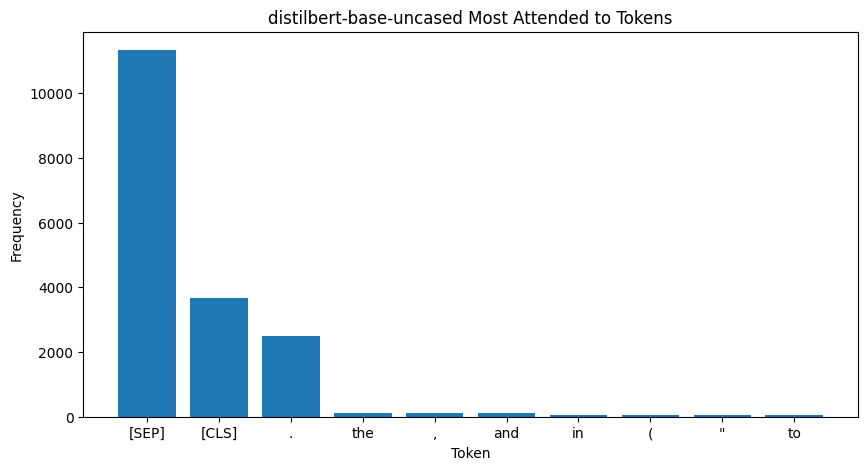

In [94]:
# Plot the histogram of the most attended to tokens
plt.figure(figsize=(10, 5))
plt.bar(highest_attention_token.keys(), highest_attention_token.values())
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title(f"{model_name} Most Attended to Tokens")
plt.show()


In [120]:
# Sanity check to ensure attention scores sum to 1 for a given layer and document
torch.allclose(attention_weights[0][0].sum(dim=1), torch.ones(dtype=torch.float32, size=(len(attention_weights[0][0]),)))



True

## Visualizing Attention Heat Maps For a Given Document

The function `plot_attention_weights_batch_wise` is designed to visualize the attention weights of a language model for a specific batch of data. 

Here's a detailed breakdown of its purpose and functionality:

- **Parameters:**
  - `attention_weights`: A list of PyTorch tensors representing the attention weights for each layer in a model. Each tensor has a shape of [batch_size, num_tokens, num_tokens].
  - `tokens`: A list of lists, where each inner list contains the tokens in a sequence.
  - `batch_index`: An integer representing the index of the batch to visualize.
  - `model_type`: A string indicating the type of the model. It can be 'encoder', 'decoder', or 'encoder-decoder'.
  - `pad_start_idx`: A list of integers representing the indices of the first pad token in each sequence.
  - `non_pad_start_idx`: A list of integers representing the indices of the first non-pad token in each sequence.
  - `model_name`: A string representing the name of the model.

- **Functionality:**
  - The function first sets up a plot with a subplot for each layer in the model.
  - It then determines whether to avoid plotting pad tokens based on the `model_type`.
  - For each layer, it extracts the attention weights for the specified batch and plots them as a heatmap. The x and y axes of the heatmap represent the timesteps of the encoder and decoder, respectively, and the color of each cell represents the attention weight.
  - Each subplot is labeled with the layer number and the model name, and a color bar is added to indicate the scale of the attention weights.
  - Finally, it adjusts the size of the subplots for better visualization and displays the plot.

- **Returns:**
  - This function does not return any value. Its purpose is to generate a visualization of the attention weights.

This function is useful for understanding how a model pays attention to different tokens at each layer when processing a sequence of text.

In [126]:
def plot_attention_weights_batch_wise(attention_weights, tokens, batch_index, model_type, pad_start_idx, non_pad_start_idx, model_name):
  """
  This function plots the attention weights for each layer in the model for a given batch index.
  
  Args:
    attention_weights (List[torch.Tensor]): The attention weights for each layer
    tokens (List[List[str]]): The tokens for each document in the batch
    batch_index (int): The batch index
    model_type (str): The type of model to be used
    pad_start_idx (List[int]): The indices of the first pad token in each document in the batch
    non_pad_start_idx (List[int]): The indices of the first non-pad token in each document in the batch
    model_name (str): The name of the model
  """      
  # Set up the plot
  fig, axs = plt.subplots(nrows=len(attention_weights)//3, ncols=3, figsize=(30, 30))

  # We want to avoid plotting pad_tokens
  if model_type == ModelTypes.ENCODER:
    token_offset = pad_start_idx[batch_index]
  else:
    token_offset = non_pad_start_idx[batch_index]
  # Plot the attention weights for each layer
  for layer_num, ax in enumerate(axs.flat):
      if model_type == ModelTypes.ENCODER:
        tick_labels = tokens[batch_index][:token_offset]
        attention_weights_to_plot = attention_weights[layer_num][batch_index][:token_offset,:token_offset]
      else:
        tick_labels = tokens[batch_index][token_offset:]
        attention_weights_to_plot = attention_weights[layer_num][batch_index][token_offset:,token_offset:]
      sns.heatmap(attention_weights_to_plot, ax=ax, cmap='YlGnBu', cbar_kws={'label': 'Attention weight', 'orientation': 'vertical', 'fraction': 0.046, 'pad': 0.04}, cbar=True, xticklabels=tick_labels, yticklabels=tick_labels)
      ax.set_title(f'{model_name} Attention Scores for Layer {layer_num+1}')
      ax.set_xlabel('Encoder timestep')
      ax.set_ylabel('Decoder timestep')

  # Adjust the size of the subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

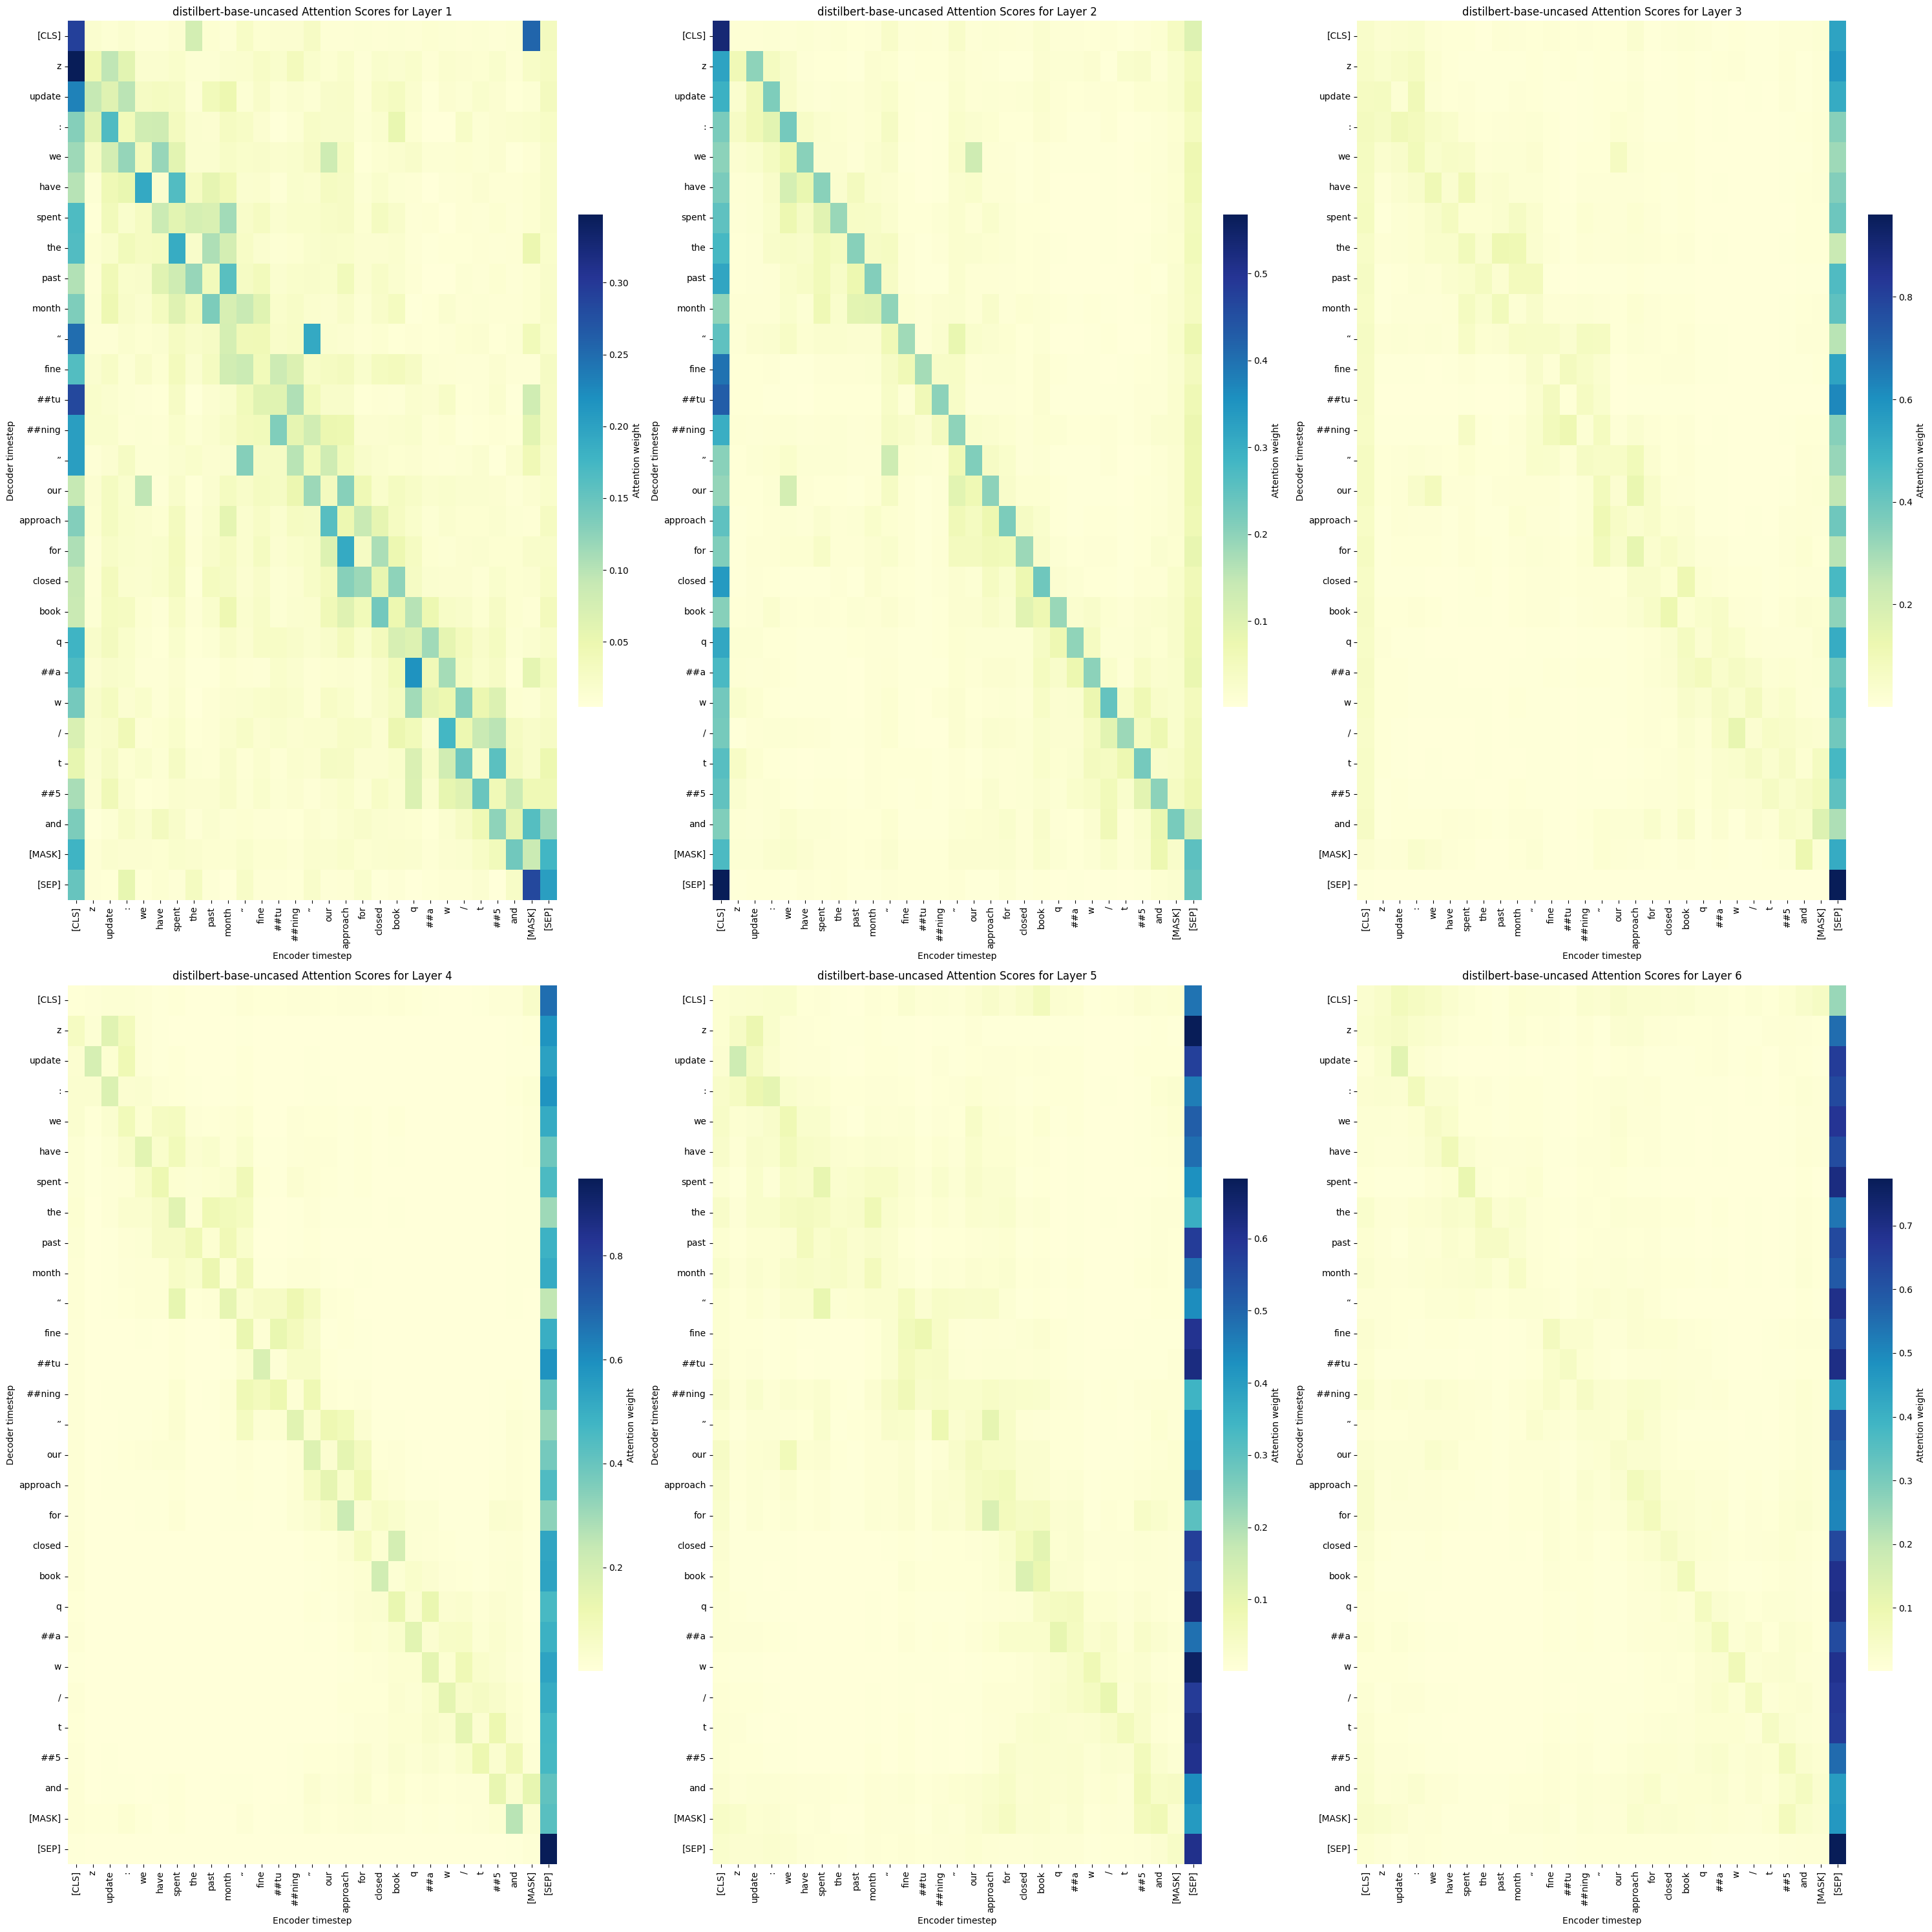

In [127]:
plot_attention_weights_batch_wise(attention_weights, tokens, 1, model_type, pad_start_idx, non_pad_start_idx, model_name)

### Visualizing Attention Heat Maps For a Given Layer


In [124]:
def plot_attention_weights_layer_wise(attention_weights, tokens, layer_index, model_type, pad_start_idx, non_pad_start_idx, model_name):
    """
    This function plots the attention weights of all the elements in the batch for a given layer.
    """
    # Set up the plot
    fig, axs = plt.subplots(nrows=len(attention_weights[0]), ncols=1, figsize=(25, 100))

    # Plot the attention weights for each layer
    for batch_index, ax in enumerate(axs.flat):
        # We want to avoid plotting pad_tokens
        if model_type == ModelTypes.ENCODER:
            token_offset = pad_start_idx[batch_index]
        else:
            token_offset = non_pad_start_idx[batch_index]
        if model_type == ModelTypes.ENCODER:
          tick_labels = tokens[batch_index][:token_offset]
          attention_weights_to_plot = attention_weights[layer_index][batch_index][:token_offset,:token_offset]
        else:
          tick_labels = tokens[batch_index][token_offset:]
          attention_weights_to_plot = attention_weights[layer_index][batch_index][token_offset:,token_offset:]
        sns.heatmap(attention_weights_to_plot, ax=ax, cmap='YlGnBu', cbar_kws={'label': 'Attention weight', 'orientation': 'vertical', 'fraction': 0.02, 'pad': 0.04}, cbar=True, xticklabels=tick_labels, yticklabels=tick_labels)
        ax.set_title(f'{model_name} Attention Scores at Layer {layer_index} for Batch {batch_index}')
        ax.set_xlabel('Encoder timestep')
        ax.set_ylabel('Decoder timestep')


    # Adjust the size of the subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

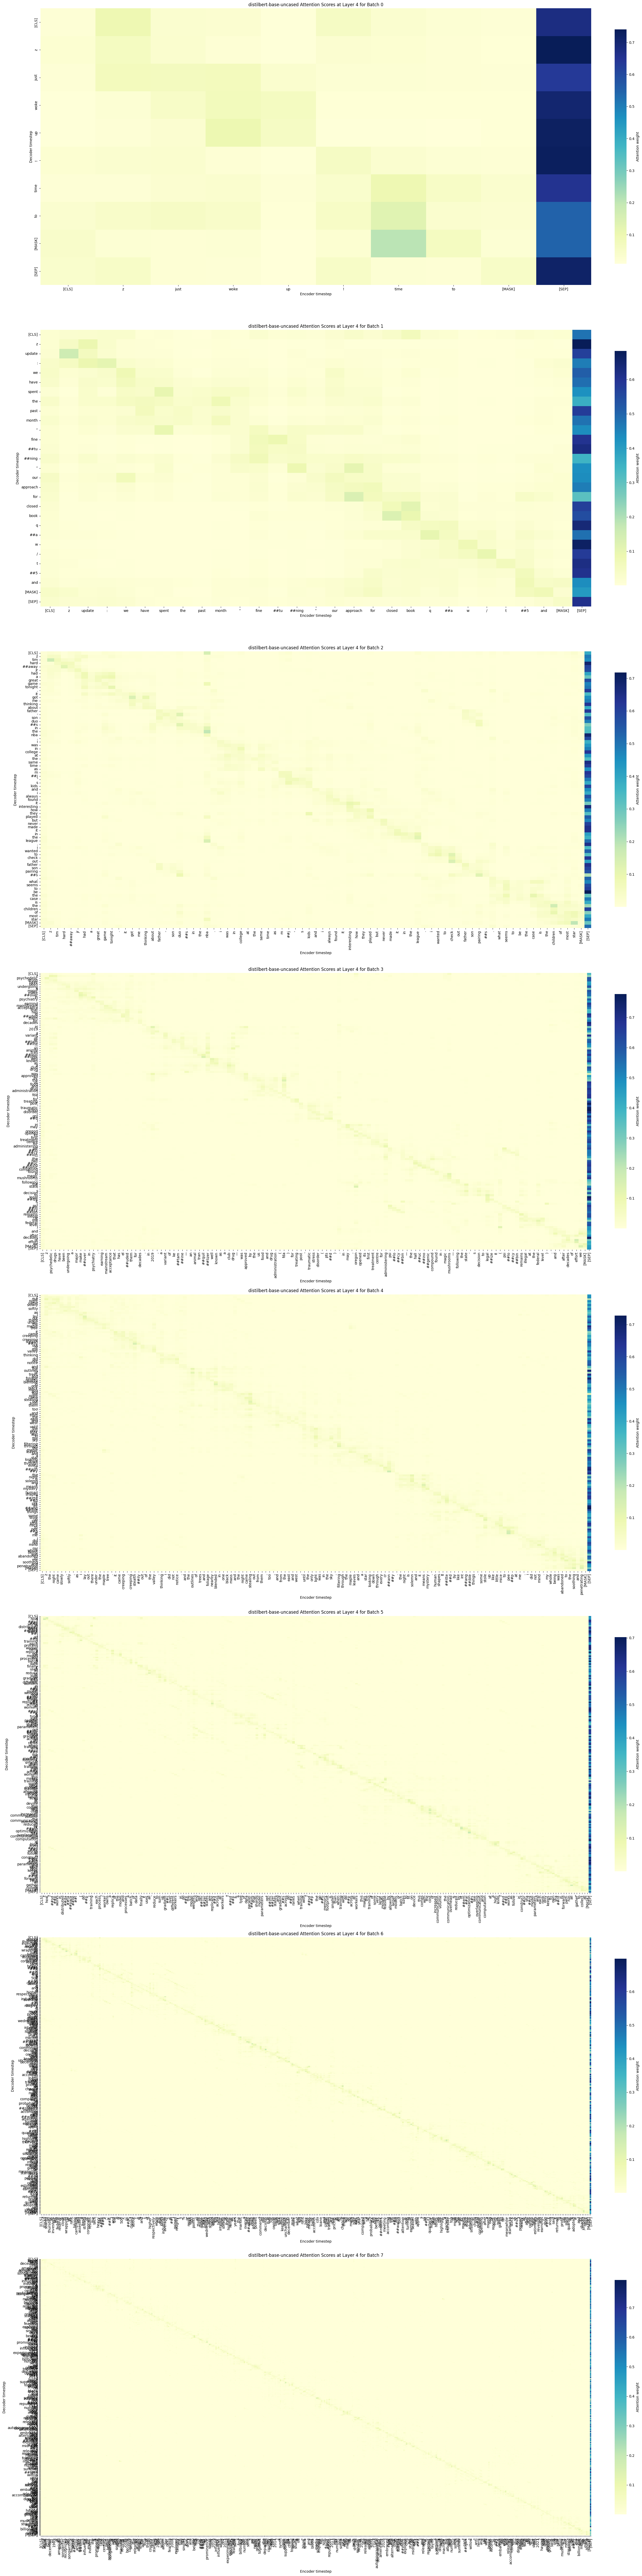

In [128]:
plot_attention_weights_layer_wise(attention_weights, tokens, 4, model_type, pad_start_idx, non_pad_start_idx, model_name)

In [134]:
# 36 is for the number of layers
special_token_attention_scores = defaultdict(lambda: [[] for _ in range(36)])

## Quantifying Magnitude of Attention Paid to Special Tokens

We'd like to observe the absolute magnitude of attention scores offloaded to the special tokens. A large magnitude indicates that these tokens are indeed being used as sinks.

In order to do this we compute the average attention each token pays to each of the special tokens that we found earilier, and store these values on a per-layer basis.

In [135]:
# Get the attention weights for the special tokens across all layers, average scores across all tokens
for layer_index in range(len(attention_weights)):
    for batch_ind in range(len(attention_weights[layer_index])):
        for special_token in special_tokens:
            special_token_index = special_token[batch_ind]
            if found_special_tokens:
                token_name = tokens[batch_ind][special_token_index]
            else:
                token_name = "[POSITION_0]"
            special_token_attention_scores[token_name][layer_index]\
            .append(torch.mean(attention_weights[layer_index][batch_ind, non_pad_start_idx[batch_ind]:, special_token_index]).item())


## Plot Magnitude of Attention For Special Tokens

The function `plot_attention_histograms` is designed to create a series of histograms, each representing the distribution of attention scores for a specific special token across different layers of a language model.

Here's a detailed breakdown of its purpose and functionality:

- **Parameters:**
  - `special_token_attention_scores`: A dictionary where the keys are special token names and the values are lists of attention scores for each layer in the model.

- **Functionality:**
  - The function iterates over each key in the `special_token_attention_scores` dictionary. Each key represents a special token.
  - For each special token, it retrieves the attention scores and creates a grid of subplots, one for each layer in the model.
  - It then flattens the axes array to make it easier to iterate over.
  - For each layer, if there are attention scores available, it plots a histogram of the attention scores on the corresponding subplot. The x-axis represents the attention score and the y-axis represents the frequency of that score.
  - Each subplot is labeled with the layer number and the special token name.
  - After plotting all layers, it adjusts the layout for better visualization and displays the plot.

- **Returns:**
  - This function does not return any value. Its purpose is to generate a visualization of the attention scores.

This function is useful for understanding how a model pays attention to specific special tokens at each layer when processing a sequence of text.

In [138]:
def plot_attention_histograms(special_token_attention_scores: Dict[str, List[List[float]]]):
    """
    This function plots the histogram of the attention scores for each special token across all layers.

    Args:
        special_token_attention_scores (Dict[str, List[List[float]]]): 
            The attention scores for each special token across all layers
    """
    # Loop over each key in the special_token_attention_scores dictionary
    for key in special_token_attention_scores.keys():
    # Get the attention scores for the current key
        attention_scores = special_token_attention_scores[key]
        _, axs = plt.subplots(nrows=len(attention_weights)//3, ncols=3, figsize=(20, 10))
        axs = axs.flatten()  # Flatten the axes array
        # Loop over each layer in the attention_scores list
        for i, layer_scores in enumerate(attention_scores):
            if layer_scores:
                # Plot a histogram of the attention scores for the current layer
                axs[i].hist(layer_scores, bins=5)
                axs[i].set_title(f'Attention scores for "{key}" in layer {i+1}')
                axs[i].set_xlabel('Attention score')
                axs[i].set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()

In [130]:
#special_token_attention_scores

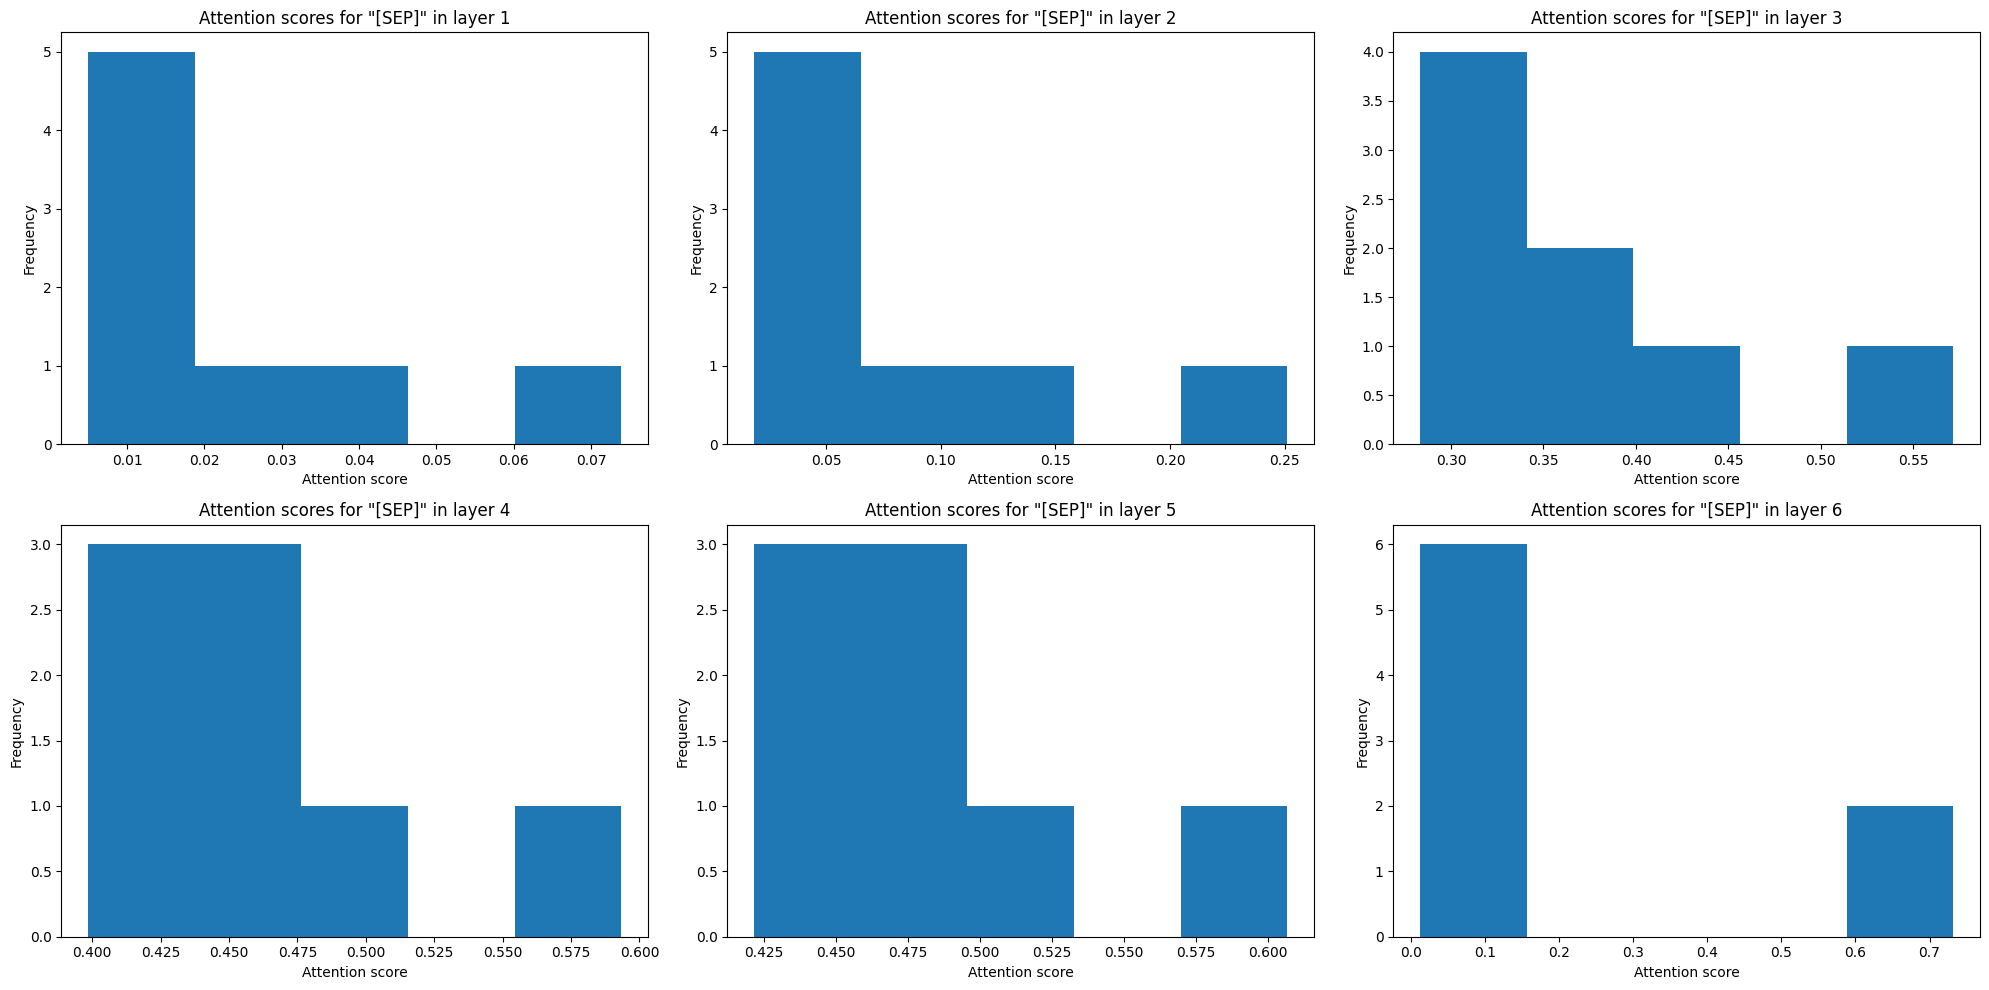

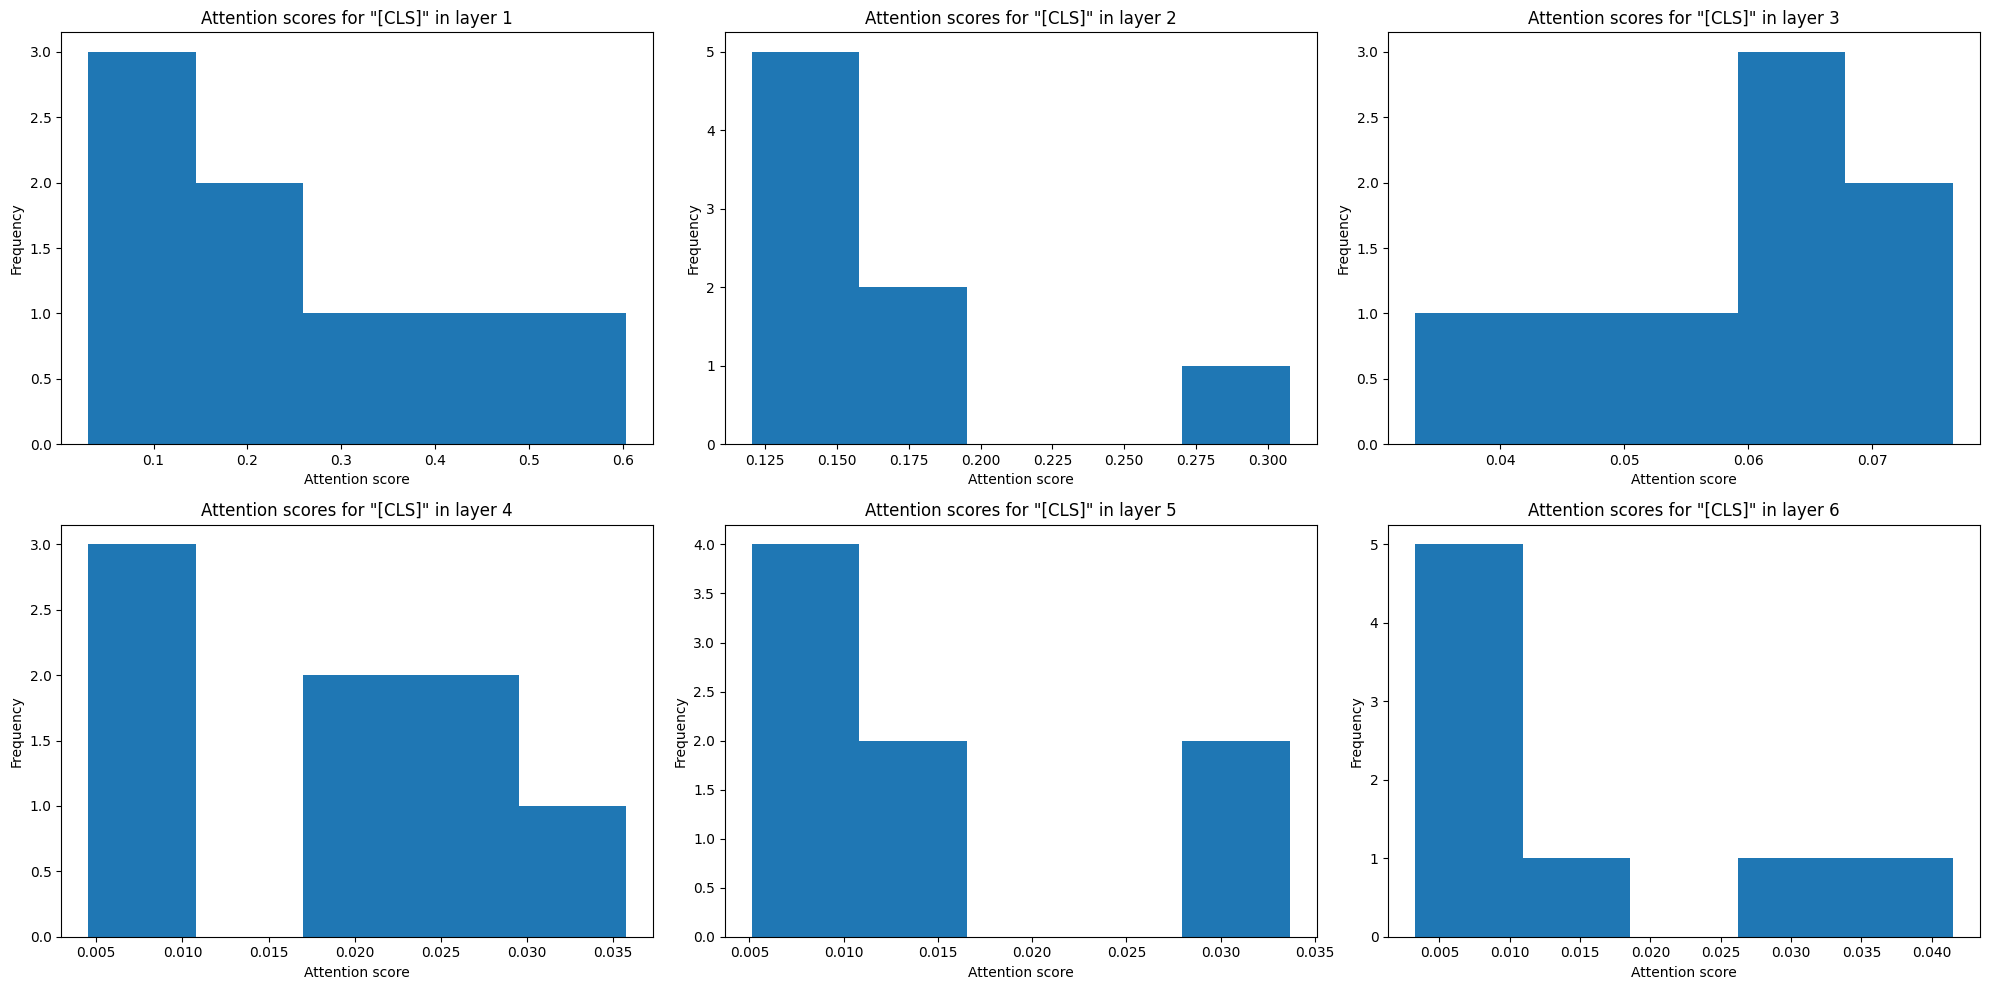

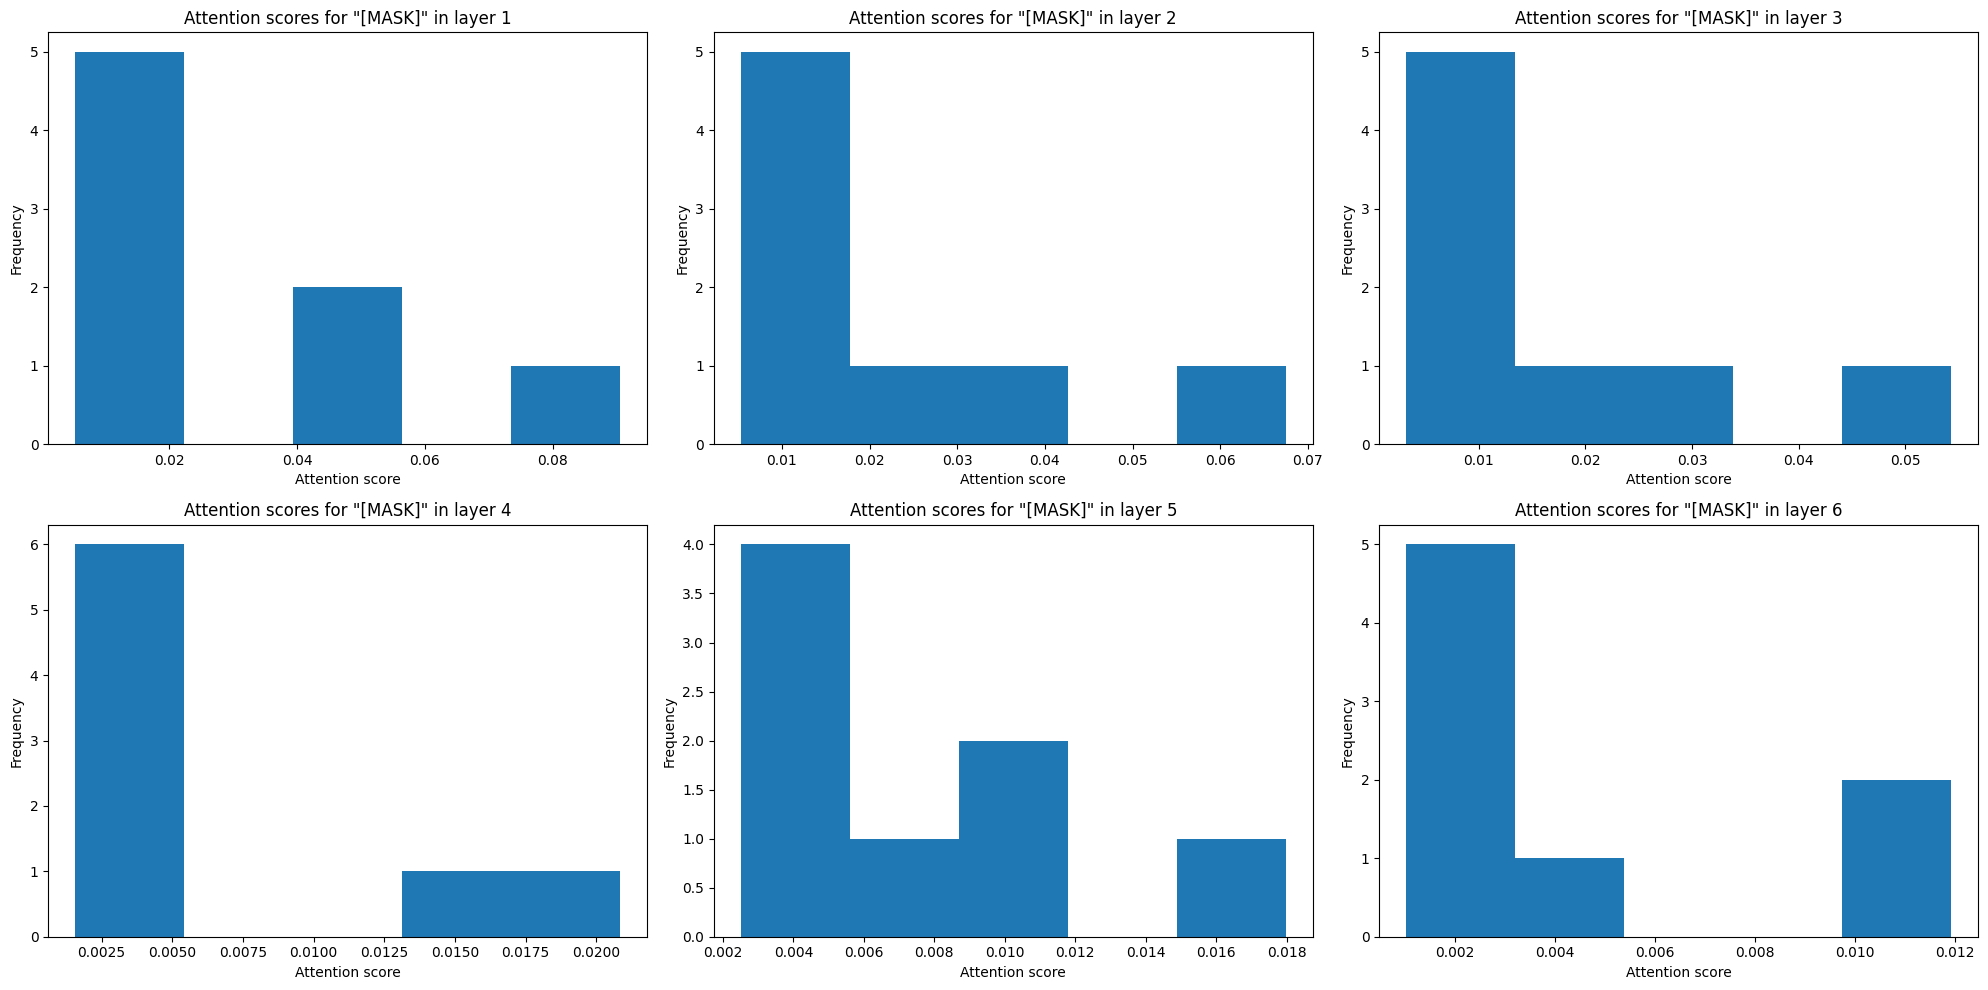

In [139]:
# Assuming you have a dictionary called `special_token_attention_scores`
plot_attention_histograms(special_token_attention_scores)